<a id='head'></a>

# Токсичные комментарии (проект для «Викишоп»)

# Оглавление
 
- [**Введение**](#intro)
    - [Цели исследования](#purpose)
    - [Входные данные](#input_data)
    - [Ход исследования](#progress)
    
- [**1. Обзор данных**](#part_1)
    - [1.1 Импорт библиотек и данных](#part_1_1)
    - [1.2 Обзор данных](#part_1_2)
    - [Выводы](#part_1_conclusions)

- [**2. Подготовка**](#part_2)
    - [2.1 Очистка текста](#part_2_1)
    - [2.2 Лемматизация](#part_2_2)
    - [2.3 Создание выборок](#part_2_3)
    - [2.4 Создание матриц признаков](#part_2_4)

- [**3. Обучение**](#part_3)
    - [3.1 Функции для моделей](#part_3_1)
    - [3.2 Logistic Regression](#part_3_2)
    - [3.3 Light GBM](#part_3_3)
    - [3.4 XGBoost](#part_3_4)
    - [3.5 Dummy Classifier](#part_3_5)
    - [3.6 Результаты обучения моделей](#part_3_6)

- [**4. Выводы**](#part_4)
    - [4.1 Часть](#part_4_1)
    - [Выводы](#part_4_conclusions)

- [Чек лист](#check_list)

<a id='intro'></a>
# Введение [▴](#head)

Интернет-магазин **«Викишоп»** запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

<a id='purpose'></a>
## Цели исследования [▴](#head)

- Обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.
- Необходимо построить модель со значением метрики качества `F1` не меньше `0.75`

<a id='input_data'></a>
## Входные данные [▴](#head)

Данные находятся в файле `/datasets/toxic_comments.csv`

Столбцы:
- `text` — содержит текст комментария 
- `toxic` — целевой признак

<a id='progress'></a>
## Ход исследования [▴](#head)

1. Загружаем и готовим данные.
2. Обучаем разные модели.
3. Делаем выводы.

<a id='part_1'></a>
# 1. Обзор данных [▴](#head)

<a id='part_1_1'></a>
## 1.1 Импорт библиотек и данных [▴](#head)

In [1]:
import re
import time
import nltk
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm import notebook
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_extraction.text import TfidfVectorizer

**Скачиваем необходимые данные для библиотеки NLTK**

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mustd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mustd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mustd\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mustd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mustd\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

**Установка параметров**

In [3]:
full_start = time.time() # Таймер, который покажет время выполнения всей тетрадки
plt.rcParams.update({'font.size':15}) # зададим размер шрифта по умолчанию для графиков

**Импорт данных**

In [4]:
# для того чтобы код работал Локльно и на Практикуме используем конструкцию Try... Except

try:
    df = pd.read_csv('datasets/toxic_comments.csv', index_col='Unnamed: 0') # Локально
except:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col='Unnamed: 0') # Практикум

<a id='part_1_2'></a>
## 1.2 Обзор данных [▴](#head)

Для предварительного обзора данных используем заранее заготовленную функцию

In [5]:
def overview(o_df):
    print('\nОбщий вид')
    display(o_df.head())
    
    print('\nКоличество полных дубликатов:', o_df.duplicated().sum())
    
    print('\n.info()\n')
    o_df.info()

    df_i = o_df.isna().sum().index
        
    df_na_sum = o_df.isna().sum().values
    df_na_part = round(o_df.isna().sum() / o_df.shape[0] * 100, 1).values
    display(pd.DataFrame({'Количество пропусков': df_na_sum, 'Процент пропусков %': df_na_part}, index=df_i)) 
    
    print('\n.describe(числовых значений датафрейма)')
    display(o_df.describe())

In [6]:
overview(df)


Общий вид


,text,toxic
0,Explanation\r\nWhy the edits made under my use...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\r\nMore\r\nI can't make any real suggestions...",0
4,"You, sir, are my hero. Any chance you remember...",0



Количество полных дубликатов: 0

.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,Количество пропусков,Процент пропусков %
text,0,0.0
toxic,0,0.0



.describe(числовых значений датафрейма)


,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Посмотрим на распределение классов

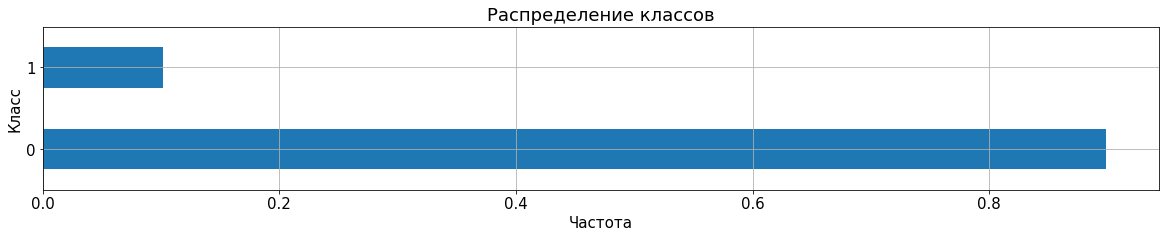

In [7]:
(
    df['toxic']
    .value_counts(normalize=df['toxic'].sum()/df.shape[0])
    .plot.barh(figsize=(20, 3), grid=True)
)

plt.title('Распределение классов')
plt.xlabel('Частота')
plt.ylabel('Класс')
plt.show()

<a id='part_1_conclusions'></a>
## Выводы [▴](#head)

- ✅ Во входном датасете нет дубликатов и пропусков
- ⚠️ Датасет достаточно массивный 160 тысяч строк. Для первоначальной обработки и настройки моделей возьмем 10% от него, чтобы не нагружать систему и не тратить лишнее время. [**Вот ячейка**](#frac) которая за это отвечает.
- ⚠️ Есть достаточно сильный дисбаланс классов, надо это учесть при обучении логистической регрессии так как она наиболее восприимчива к этому.
- ⚠️ Индексы идут не монолитно. Сбросим индексы, чтобы можно было делать перебор строк во время обработки.
- ⛔️ Текст содержит много мусора, а так же не лемматизирован. От этого надо избавиться чтобы повысить качество обучения.

<a id='part_2'></a>
# 2. Подготовка [▴](#head)

<a id='frac'></a>
Для начала уменьшим наш датасет. 

Перед финальным тестированием заккоментируем эту ячейку.

In [8]:
# Берем 10% от датасета для ускорения выполнения тетрадки

# df = df.sample(frac=0.1, random_state=12345).copy() 

Сбросим индексы, чтобы они шли монолитно и по порядку.

In [9]:
df = df.reset_index(drop=True)

<a id='part_2_1'></a>
## 2.1 Очистка текста [▴](#head)

Для начала напишем функцию `clear_text()`, которая будет очищать текст от любых спецсимволов и лишних пробелов

Функция:
- **`Принимает:`** строку текста
- С помощью регулярных выражений все кроме символов `a-z` и `A-Z` меняет на пробелы
- Разбивает измененную строку на список элементов (все пробелы при этом анулируются)
- Объединяет список методом `.join()` обратно в строку через пробел
- **`Возвращает:`** очищенную строку без лишних пробелов



In [10]:
def clear_text(text):
    clear = re.sub(r'[^a-zA-Z ]', ' ', text)
    clear = clear.split()
    clear = " ".join(clear)
    return clear

Функцией обойдем все строки датасета, результат работы функции поместим в новый столбец `clear_text`.

Функция примененная векторно `df['text'].apply(clear_text)` отработает немного быстрее, но через цикл мы можем видеть, что процесс не умер и примерно понимать сколько он займет.

In [11]:
%%time
for i in notebook.tqdm(range(len(df))):
    df.loc[i, 'clear_text'] = clear_text(df.loc[i, 'text'])

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: total: 42.8 s
Wall time: 41.3 s


In [12]:
display(df.head())

,text,toxic,clear_text
0,Explanation\r\nWhy the edits made under my use...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\r\nMore\r\nI can't make any real suggestions...",0,More I can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...


Функция отработала корректно

<a id='part_2_2'></a>
## 2.2 Лемматизация [▴](#head)

Для лемматизации применим инструменты из библиотеки `nltk`. Для того, чтобы автоматизировать процесс напишем функцию `lemmatize_text()`

Функция:
- **`Принимает:`** строку текста
- Из строки делает список слов (токенов) с помощью токенизитора `nltk.word_tokenize()`
- С помощью цикла обходит каждый токен, лемматизирует его с помощью класса `WordNetLemmatizer()`, готовый список лемматизированных токенов сшивает обратно в строку
- **`Возвращает:`** лемматизированную строку

In [13]:
wnl = WordNetLemmatizer()

def lemmatize_text(text):
    list_to_token = nltk.word_tokenize(text)
    lem_text = ' '.join([wnl.lemmatize(word, pos='v') for word in list_to_token])
    return lem_text

Функцией обойдем все строки датасета, результат работы функции поместим в новый столбец `lemm_text`.

Функция примененная векторно `df['clear_text'].apply(lemmatize)` отработает немного быстрее, но через цикл мы можем видеть, что процесс не умер и примерно понимать сколько он займет.

In [14]:
%%time
for i in notebook.tqdm(range(len(df))):
    df.loc[i, 'lemm_text'] = lemmatize_text(df.loc[i, 'clear_text'])

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: total: 4min 38s
Wall time: 4min 38s


In [15]:
display(df.head())

,text,toxic,clear_text,lemm_text
0,Explanation\r\nWhy the edits made under my use...,0,Explanation Why the edits made under my userna...,Explanation Why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...,D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...,Hey man I m really not try to edit war It s ju...
3,"""\r\nMore\r\nI can't make any real suggestions...",0,More I can t make any real suggestions on impr...,More I can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,You sir be my hero Any chance you remember wha...


Функция отработала корректно

<a id='part_2_3'></a>
## 2.3 Создание выборок [▴](#head)

Сначала разобьем наш датасет на `признаки` и `целевые признаки`

Затем сделаем тренировочные `X_train` `y_train` и тестовые `X_test` `y_test` выборки в соотношении `75% / 25%`, стратифицируем выбоки чтобы классы распределились равномерно.

In [16]:
features = df['lemm_text'].copy()
target = df['toxic'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    features, 
    target, 
    random_state=12345, 
    test_size=0.25, 
    stratify=target)

Проверим размер выборок

In [17]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (119469,)
y_train: (119469,)
X_test: (39823,)
y_test: (39823,)


<a id='part_2_4'></a>
## 2.4 Создание матриц признаков [▴](#head)

Оценим важность слов величиной `TF-IDF`, для этого используем класс `TfidfVectorizer()`

Дополнительно:
- выбросим из массива стоп-слова с помощью библиотеки `nltk.stopwords`
- разобьем текст на `униграммы` и `биграммы` для более качественного обучения моделей.
- обучим функцию на тренировочной выборке, чтобы  не произошла утечека признаков в тестовую выборку.

In [18]:
stopwords = set(nltk_stopwords.words('english'))
tf_idf_vectorizer = TfidfVectorizer(stop_words=stopwords,
                                    ngram_range=(1, 2))
tf_idf_vectorizer.fit(X_train)

TfidfVectorizer(ngram_range=(1, 2),
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

Трансформируем наши выборки в матрицы признаков.

In [19]:
X_train = tf_idf_vectorizer.transform(X_train)
X_test = tf_idf_vectorizer.transform(X_test)

In [20]:
display(X_train)
display(X_test)

<119469x2032372 sparse matrix of type '<class 'numpy.float64'>'
	with 6883038 stored elements in Compressed Sparse Row format>

<39823x2032372 sparse matrix of type '<class 'numpy.float64'>'
	with 1749024 stored elements in Compressed Sparse Row format>

Все готово для обучения.

<a id='part_3'></a>
# 3. Обучение [▴](#head)

<a id='part_3_1'></a>
## 3.1 Функции для моделей [▴](#head)

Создадим пустые списки для сбора результатов тестирования моделей.

In [21]:
models = []
results = []
learn_time = []

Функция `auto_grid()`:
- **`Принимает:`** модель, набор гиперпараметров для перебора
- Обучает модель перебирая гиперпараметры с помощью функции `GridSearchCV()`
- Для кросс валидации используется функция `StratifiedKFold()` для того, чтобы выборки получались стратифицированными
- Выбирает лучшие гиперпараметры на основе оценки результата метрикой `F1 score`
- **`Сообщает:`** лучший результат модели, набор гиперпараметров на которых он был получен, время работы функции
- **`Возвращает:`** словарь гиперпараметров на которых был достигнут лучший результат.

In [22]:
def auto_grid(search_model, params):
    
    start = time.time()
    skf = StratifiedKFold(n_splits=3)
    
    grid_search = GridSearchCV(estimator=search_model,
                               param_grid=params,
                               cv=skf,
                               scoring='f1',
                               n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    
    stop = time.time()
    
    best_score = round(grid_search.best_score_, 3)
    best_params = grid_search.best_params_
    
    print(f'Лучший f1_score модели: {best_score}')
    print(f'Параметры лучшей модели: {best_params}')
    print(f'Время выполнения ячейки: {stop - start:.0f} секунд')
    
    return best_params

Функция `learn_model()`: 
- **`Принимает:`** модель с указанными гиперпараметрами
- Обучает модель на выборках `X_train` и `y_train`
- Замеряет `F1 score` на тестовой выборке `X_test`
- Добавляет `F1 score` полученный на тестовой выборке в список `results`
- Добавляет время обучения модели в список `learn_time`
- **`Сообщает:`** `F1 score` полученный на тестовой выборке, время обучения модели

In [23]:
def learn_model(learning_model):
    
    start = time.time()
    model.fit(X_train, y_train)    
    stop = time.time()
    
    predictions = model.predict(X_test)
    
    f1_score_val = round(f1_score(y_test, predictions), 3)
    wall_time = round(stop - start, 0)
    
    results.append(f1_score_val)
    learn_time.append(wall_time)
    
    print(f'f1_score тестовой выборки: {f1_score_val}')
    print(f'Время обучения модели: {wall_time} секунд')

Настало время обучаться. 

Ячейки с запуском функции `GridSearch` закомментированы, результат их работы размещен в блоке ниже.

Если код выполнялся бы монолитно с этими функциями, то лучшие гиперпараметры автоматически попадали бы в модель для тестирования.  В данном случае словарь заполнен вручную.

<a id='part_3_2'></a>
## 3.2 Logistic Regression [▴](#head)

In [24]:
model = LogisticRegression(solver='liblinear', random_state=12345)
params = {'class_weight': ['balanced', None]}

In [25]:
# best_params = auto_grid(model, params)

    Лучший f1_score модели: 0.642
    Параметры лучшей модели: {'class_weight': 'balanced'}
    Время выполнения ячейки: 3 секунд

In [26]:
best_params = {'class_weight': 'balanced'}

model = LogisticRegression(solver='liblinear', random_state=12345, **best_params)
models.append('Logistic Regression')

In [27]:
learn_model(model)

f1_score тестовой выборки: 0.757
Время обучения модели: 9.0 секунд


<a id='question'></a>

<a id='part_3_3'></a>
## 3.3 Light GBM [▴](#head)

In [28]:
model = lgb.LGBMClassifier(random_state=12345)
params = {'max_depth': [6, 7],
          'n_estimators': [500, 2000],
          'learning_rate': [0.1, 0.05]}

In [29]:
# best_params = auto_grid(model, params)

    Лучший f1_score модели: 0.627
    Параметры лучшей модели: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 2000}
    Время выполнения ячейки: 36 секунд

In [30]:
best_params = {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 2000}
model = lgb.LGBMClassifier(random_state=12345, **best_params)
models.append('LightGBM')

In [31]:
learn_model(model)

f1_score тестовой выборки: 0.773
Время обучения модели: 105.0 секунд


<a id='part_3_4'></a>
## 3.4 XGBoost [▴](#head)

In [32]:
model = xgb.XGBClassifier(random_state=12345)

params = {'max_depth': [8, 10],
          'n_estimators': [400, 500],
          'learning_rate': [0.1, 0.05]}

In [33]:
# best_params = auto_grid(model, params)

    Лучший f1_score модели: 0.654
    Параметры лучшей модели: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 400}
    Время выполнения ячейки: 320 секунд

In [34]:
best_params = {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 400}
model = xgb.XGBClassifier(random_state=12345, **best_params)
models.append('XGBoost')

In [35]:
learn_model(model)

f1_score тестовой выборки: 0.751
Время обучения модели: 359.0 секунд


<a id='part_3_5'></a>
## 3.5 Dummy Classifier [▴](#head)

In [36]:
model = DummyClassifier(random_state=12345)
models.append('Dummy Classifier')

In [37]:
learn_model(model)

f1_score тестовой выборки: 0.0
Время обучения модели: 0.0 секунд


<a id='part_3_6'></a>
## 3.6 Результаты обучения моделей [▴](#head)

In [38]:
results_df = pd.DataFrame({'F1 score': results, 'Время обучения, сек.': learn_time}, 
                          index=models)
display(results_df)

,F1 score,"Время обучения, сек."
Logistic Regression,0.757,9.0
LightGBM,0.773,105.0
XGBoost,0.751,359.0
Dummy Classifier,0.000,0.0


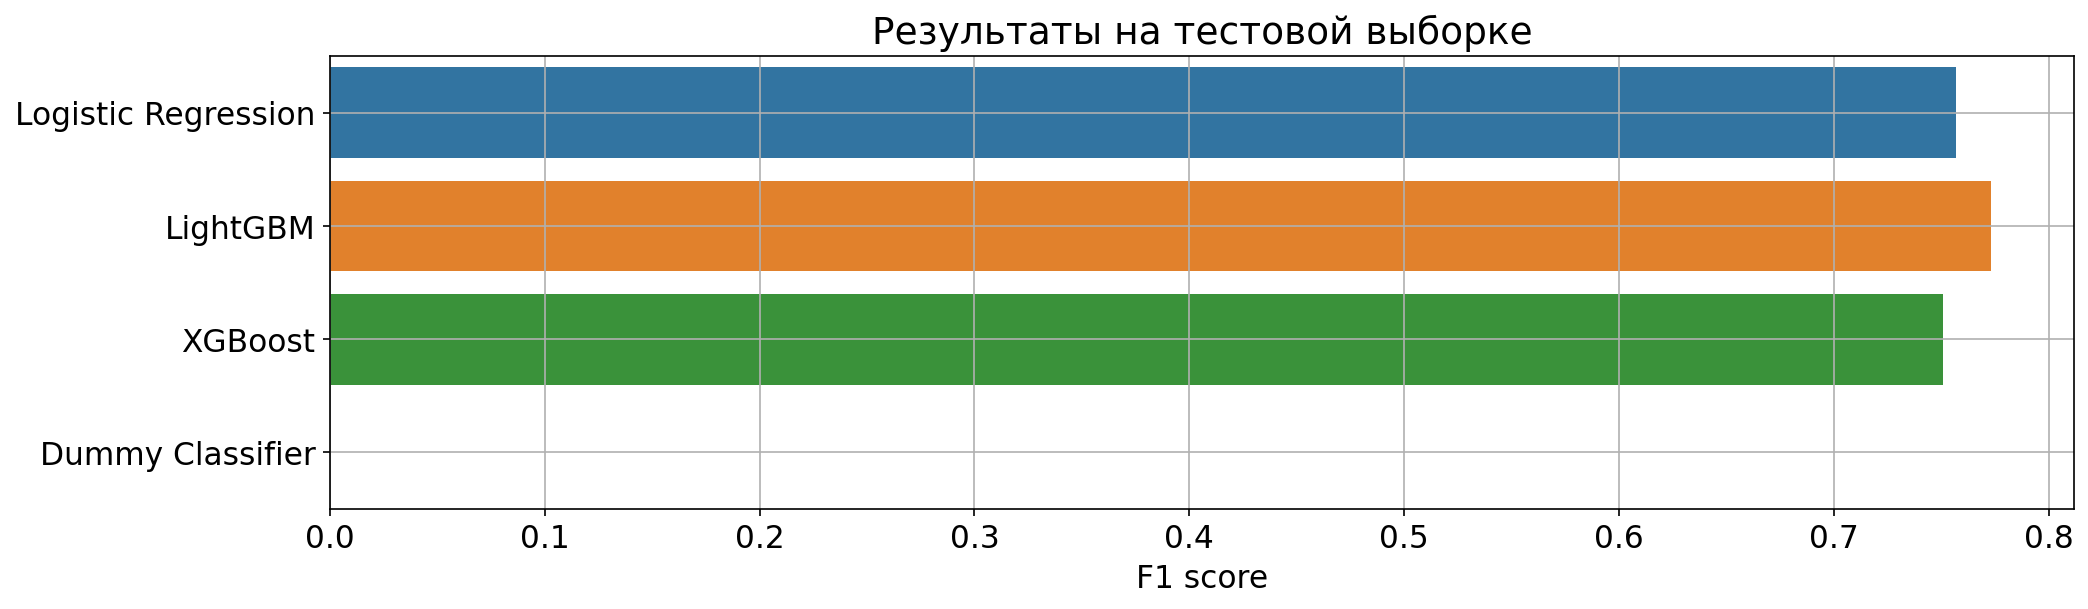

In [41]:
plt.figure(figsize=(15,4), dpi=150)

sns.barplot(y=results_df.index,
            x=results_df['F1 score'],
            orient='h')

plt.title('Результаты на тестовой выборке')
plt.xlabel('F1 score')
plt.grid()
plt.show()

**Результаты полученные на полном датасете:**

Модель|F1 score|Время обучения, сек.
-|-|-
**Logistic Regression**|0.757|9.0
**LightGBM**|0.773|105.0
**XGBoost**|0.751|355.0
**Dummy Classifier**|0|0

<a id='part_4'></a>
# 4. Выводы [▴](#head)

- В результате нашего исследования лучшей по качеству оказалась модель `LightGBM`, однако если учитывать скорость обучения то в лидеры однозначно выбивается `Логистическая Регрессия`, так как она не сильно проигрывает по качеству. Самое главное запускать ее с параметром `class_weight='balanced'` так как модель достаточно чуствительна к дисбалансу.
- При проверке моделей на адекватность `Dummy Classifier` показала нулевой результат. Что подтверждает, что наши модели обучились адекватно.
- Входные данные не содержали пропусков и повторов, но были сильно зашумлены посторонними для моделей символами, а так же текст не был лемматизирован. Перед обучением мы решили эти проблемы.
- В самом начале мы уменьшили входной датасет в 10 раз, это позволило очень сильно сократить время затраченное на решение задачи. Так как исходный датасет содержал порядка 160 тысяч записей каждое обращение к такому массиву данных занимало продолжительное время и тормозило процесс. На финальной отладке моделей мы вернули полный объем датасета.

<a id='check_list'></a>
## Чек-лист готовности проекта [▴](#head)

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны

In [40]:
full_stop = time.time()
notebook_time = full_stop - full_start
print(f'Общее время выполнения тетрадки: {notebook_time / 60:.1f} минут')

Общее время выполнения тетрадки: 14.5 минут
